In [1]:
!pip install nba_api
!pip install sportsreference

In [2]:
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
from scipy import stats

#Call the data from the player data .csv and truncate to only include 1989-90 seasons onward
closed_file = 'NBA PROJECTS.csv'
players = pd.read_csv(closed_file)
players = players.loc[(players['Tm'] != 'TOT')& (players['Year'] >= 1990)]

In [3]:
record_file = 'NBA Season Records.csv'
name_file = 'NBA Abbreviations.csv'
records = pd.read_csv(record_file)
names = pd.read_csv(name_file)
#Clean the data in the season column to go from str(2016-17) format to float(2017) format
ssns = []
for year in records['Season']:
    yr = int(year.split('-')[1])
    if ((10 <= yr) & (yr < 20)):
        ssns.append(float('20' + str(yr)))
    elif((0 <= yr) & (yr < 10)):
        ssns.append(float('200' + str(yr)))
    else:
        ssns.append(float('19' + str(yr)))
seasons = pd.Series(ssns)
records['Season'] = seasons
#Truncate the data to only represent seasons from 1989-90 onward (removing 2017-18 as it was not in the other dataframe)
records = records.loc[(records['Season'] >= 1990) & (records['Season'] <= 2017)]
#Remove the * after the team name denoting a playoff presence
records['Team'] = records['Team'].str.replace('*', '')
#Change the names of the teams on the record dataset to the abbreviations on the abbreviation dataset
records['Team'] = records['Team'].map(names.set_index('Team')['Abbreviation'])
#Special condition for "Charlotte Hornets." The name was not used contiguously, so additional conditions were needed
records.loc[(records['Team'].isnull() == True) & 
            (records['Season'] >= 2015), 'Team'] = records.loc[(records['Team'].isnull() == True) & 
                                                               (records['Season'] >= 2015), 'Team'].replace({np.nan:'CHA'})
records.loc[(records['Team'].isnull() == True) & 
            (records['Season'] < 2015), 'Team'] = records.loc[(records['Team'].isnull() == True) & 
                                                               (records['Season'] < 2015), 'Team'].replace({np.nan:'NOP'})
records = records.rename(columns = {'Team':'Tm', 'Season':'Year'})
#Denote whether the team made the playoffs that season
records['Made Playoffs'] = records['Playoffs'].notna()

In [4]:
#Rename some of the team abbreviations to capture recent franchise movement/rename.
players = players.replace({'Tm':{'WSB':'WAS', 'VAN': 'MEM', 'NJN': 'BRK', 'SEA': 'OKC', 
                         'CHH':'NOP', 'NOH': 'NOP', 'NOK': 'NOP', 'CHO':'CHA' }})

In [5]:
#Merge the season results data with the player data. Season data is duplicated for each player
nba = pd.merge(players, records, on = ['Year', 'Tm'], how = 'left')

Text(0, 0.5, 'Pace (points per game)')

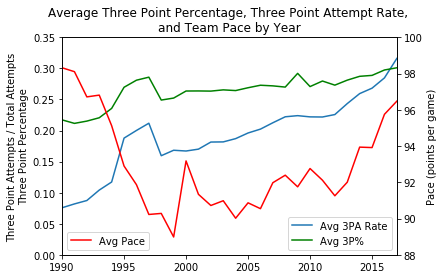

In [6]:
threes_pace = nba.groupby(['Year']).mean()[['3PA','FGA','3P%','Pace']]
attempts_percentage_pace = pd.DataFrame(threes_pace['3PA']/threes_pace['FGA'])
attempts_percentage_pace['Pace'] = threes_pace['Pace']
attempts_percentage_pace['3P%'] = threes_pace['3P%']
fig, x1 = plt.subplots()
x1.plot(attempts_percentage_pace.index, attempts_percentage_pace[0], label = 'Avg 3PA Rate')
x3 = plt.plot(attempts_percentage_pace.index, attempts_percentage_pace['3P%'], color = 'g', label = 'Avg 3P%')
plt.legend(loc = 'lower right')
plt.ylim(0, 0.35)
plt.ylabel('Three Point Attempts / Total Attempts\nThree Point Percentage')
x2 = x1.twinx()
x2 = plt.plot(attempts_percentage_pace.index, attempts_percentage_pace['Pace'], color = 'r', label = 'Avg Pace')
plt.legend(loc = 'lower left')
plt.xlim(1990, 2017)
plt.ylim(88, 100)
plt.title('Average Three Point Percentage, Three Point Attempt Rate, \nand Team Pace by Year')
plt.xlabel('Year')
plt.ylabel('Pace (points per game)')

(0.8241914625349471, 2.1747037866385124e-08)


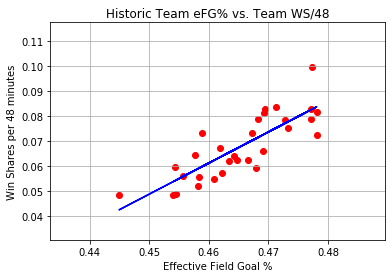

In [14]:
teams = nba.groupby(['Tm']).mean()
x = teams['eFG%']
y = teams['WS/48']
(slope, intercept, pvalue, rvalue, stderr) = stats.linregress(x,y)
line = slope * x + intercept
cor = st.pearsonr(x, y)
plt.scatter(x,y, facecolors = 'red')
plt.plot(x, line, color = "blue")
plt.grid(b = True)
plt.title('Historic Team eFG% vs. Team WS/48')
plt.xlabel('Effective Field Goal %')
plt.ylabel('Win Shares per 48 minutes')
print(cor)

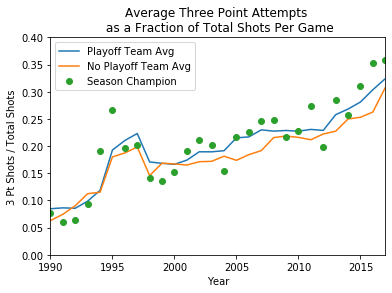

In [28]:
made_playoffs_3PA = nba.loc[nba['Made Playoffs'] == True]
winning_3PA = made_playoffs_3PA.groupby(['Year','Tm']).sum()['3PA']
winning_3PA_avg = winning_3PA.groupby(level=0).mean()
no_playoffs_3PA = nba.loc[nba['Made Playoffs'] == False]
losing_3PA = no_playoffs_3PA.groupby(['Year','Tm']).sum()['3PA']
losing_3PA_avg = losing_3PA.groupby(level=0).mean()
#
winning_attempts = made_playoffs_3PA.groupby(['Year','Tm']).sum()[['FGA','3PA']]
winning_3PA_percentage = winning_attempts['3PA']/winning_attempts['FGA']
winning_3PA_percentage_avg = winning_3PA_percentage.groupby(level=0).mean()
losing_attempts = no_playoffs_3PA.groupby(['Year','Tm']).sum()[['FGA','3PA']]
losing_3PA_percentage = losing_attempts['3PA']/losing_attempts['FGA']
losing_3PA_percentage_avg = losing_3PA_percentage.groupby(level=0).mean()
champ = nba.loc[nba['Playoffs'] == 'Won Finals']
champ_attempts = champ.groupby(['Year', 'Tm']).sum()[['FGA','3PA']]
champ_3PA_percentage = champ_attempts['3PA']/champ_attempts['FGA']
champ_3PA_percentage_avg = champ_3PA_percentage.groupby(level=0).mean()
plt.plot(winning_3PA_percentage_avg.index, winning_3PA_percentage_avg, label = 'Playoff Team Avg')
plt.plot(losing_3PA_percentage_avg.index, losing_3PA_percentage_avg, label = 'No Playoff Team Avg')
plt.plot(champ_3PA_percentage_avg.index, champ_3PA_percentage_avg, label = 'Season Champion', marker = 'o', linestyle = 'None')
plt.legend()
plt.title('Average Three Point Attempts \n as a Fraction of Total Shots Per Game')
plt.xlabel('Year')
plt.ylabel('3 Pt Shots / Total Shots')
plt.xlim(1990, 2017)
plt.ylim(0, 0.40)
plt.show()

In [29]:
shot_threes = nba.loc[nba['3PA'] != 0]
shot_threes['Playoffs'] = shot_threes['Playoffs'].fillna('No Playoffs')
ch = []
for result in shot_threes['Playoffs']:
    if result == 'Won Finals':
        ch.append(True)
    else:
        ch.append(False)
shot_threes['Champion'] = ch
team_avg = shot_threes.groupby(['Year','Tm']).mean()
team_count = shot_threes.groupby(['Year', 'Tm']).count()['Player']
team_position_avg = shot_threes.groupby(['Year','Tm', 'Pos']).mean()
team_position_count = shot_threes.groupby(['Year', 'Tm', 'Pos']).count()['Player']
teamshooting = team_avg[['3P', '3PA', '3P%', 'Made Playoffs', 'Champion']]
teamshooting_positions = team_position_avg[['3P', '3PA', '3P%']]
teamshooting_positions['Pos Counts'] = team_position_count
teamshooting_positions['Pos Avg'] = teamshooting_positions['3P%']/teamshooting_positions['Pos Counts']
teamshooting_positions['3P% Team Avg'] = teamshooting['3P%']
teamshooting_positions['3P% Diff'] = teamshooting_positions['3P%'] - teamshooting_positions['3P% Team Avg']
teamshooting_positions['Pos Var'] = (teamshooting_positions['3P% Diff'])**2
teamshooting_positions
variance = teamshooting_positions.groupby(level = [0,1]).sum()['Pos Var']
teamshooting['3P% Var'] = variance

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

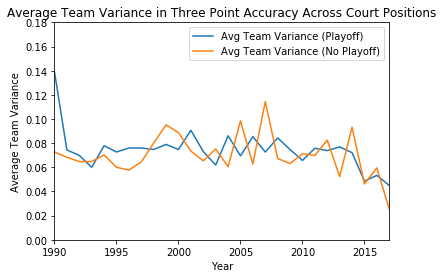

In [30]:
made_playoffs = teamshooting.loc[teamshooting['Made Playoffs'] == True]
winning_var = made_playoffs.groupby(level=0).mean()['3P% Var'].rename(columns = {'3P% Var': 'Playoff Team Avg Variance'})
no_playoffs = teamshooting.loc[teamshooting['Made Playoffs'] == False]
losing_var = no_playoffs.groupby(level=0).mean()['3P% Var'].rename(columns = {'3P% Var': 'No Playoff Team Avg Variance'})
champion = teamshooting.loc[teamshooting['Champion'] == True]
champ_var = champion.groupby(level=0).mean()['3P% Var'].rename(columns = {'3P% Var': 'Champion Team Variance'})
plt.plot(winning_var.index, winning_var, label = 'Avg Team Variance (Playoff)')
plt.plot(losing_var.index, losing_var, label = 'Avg Team Variance (No Playoff)')
plt.legend()
plt.title('Average Team Variance in Three Point Accuracy Across Court Positions')
plt.xlim(1990, 2017)
plt.ylim(0.00, 0.18)
plt.xlabel('Year')
plt.ylabel('Average Team Variance')
plt.show()

In [ ]:
threes_orbs = nba.groupby(['Year','Tm']).sum()[['FGA','3PA','ORB','DRB', 'TRB']]
attempts_percentage = threes_orbs['3PA']/threes_orbs['FGA']
orb_drb_ratio = threes_orbs['ORB']/threes_orbs['TRB']
orb_drb_ratio
plt.scatter(attempts_percentage, orb_drb_ratio)
(slope, intercept, pvalue, rvalue, stderr) = stats.linregress(attempts_percentage,orb_drb_ratio)
line = slope * attempts_percentage + intercept
cor = st.pearsonr(attempts_percentage, orb_drb_ratio)
plt.plot(attempts_percentage, line, color = "black")
plt.xlabel('Three Point Attempts / Total Attempts')
plt.ylabel('Offensive Rebounds / Total Rebounds')
plt.title('Effect of Three Point Shooting\non Offensive Rebound Capability')
cor

Enter Player Name: Kevin Love


Text(0, 0.5, '3 Point Attempts')

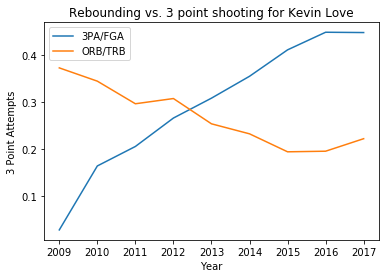

In [16]:
player = str(input('Enter Player Name: '))
ind_player= nba.loc[nba['Player'] == player][['Year','Tm','FGA','3PA','ORB','DRB', 'TRB']]
attempts_percentage_ind = ind_player['3PA']/ind_player['FGA']
orb_drb_ratio_ind = ind_player['ORB']/ind_player['TRB']
plt.plot(ind_player['Year'],attempts_percentage_ind, label = '3PA/FGA')
plt.plot(ind_player['Year'], orb_drb_ratio_ind, label = 'ORB/TRB')
plt.legend()
plt.title(f'Rebounding vs. 3 point shooting for {player}')
plt.xlabel('Year')
plt.ylabel('3 Point Attempts')
#Run Channing Frye / Kevin Love

In [22]:
from sportsreference.nba.roster import Player
pd.set_option('display.max_columns', None)

warriors_16 = ['curryst01',
'thompkl01',
'iguodan01',
'barneha02',
'bogutan01',
'greendr01',
'livinsh01',
'ezelife01',
'barbole01',
'rushbr01', 
'speigma01', 
'clarkia01', 
'mcadoja01', 
'varejan01', 
'thompja02', ]
gsw = []
#
for i in warriors_16:
    player = Player(i)
    gsw_df = player.dataframe
    gsw_df = gsw_df.loc[['2015-16']].reset_index()
    gsw_df["Player Name"]= player.name
    gsw.append(gsw_df)
#
warriors = pd.concat(gsw)
warriors['Team'] = 'Warriors'
warriors['Team Pace'] = 99.3
warriors['Team Record'] = '73-9'

In [23]:
bulls_96 = ["jordami01",
"pippesc01",
"kukocto01",
"kerrst01",
"harpero01",
"longllu01",
"rodmade01",
'wennibi01', 
'buechju01',
'simpkdi01',
'brownra02',
'caffeja01',
'edwarja01',
'haleyja01']
chi = []
#
for j in bulls_96:
    player = Player(j)
    chi_df = player.dataframe
    chi_df = chi_df.loc[['1995-96']].reset_index()
    chi_df['Player Name'] = player.name
    chi.append(chi_df)
#    
bulls = pd.concat(chi)
bulls['Team'] = 'Bulls'
bulls['Team Pace'] = 91.1
bulls['Team Record'] = '72-10'

In [24]:
GOAT = pd.concat([bulls, warriors])
GOAT = GOAT.rename(columns = {'level_0': 'Year'})

In [25]:
comp_sum = GOAT.groupby('Team').sum()
comp_avg = GOAT.groupby('Team').mean()

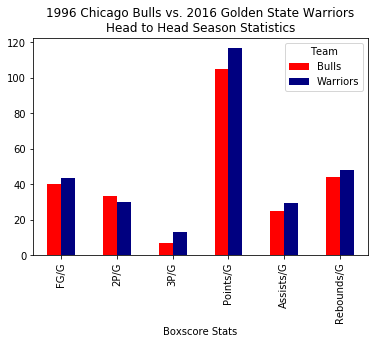

In [26]:
#box_score_graph
fg_per_game = comp_sum['field_goals'] / 82
twos_per_game = comp_sum['two_pointers'] / 82
threes_per_game = comp_sum['three_pointers'] / 82
points_per_game = comp_sum['points'] / 82
assists_per_game = comp_sum['assists'] / 82
rebounds_per_game = comp_sum['total_rebounds'] / 82
boxscore = {'FG/G' : fg_per_game, '2P/G' : twos_per_game, '3P/G' : 
         threes_per_game, 'Points/G' : points_per_game, 'Assists/G' : assists_per_game, 'Rebounds/G' : rebounds_per_game, }
boxscore = pd.DataFrame(boxscore)
boxscore_transpose = boxscore.transpose().reset_index().set_index('index')
boxscore_transpose = boxscore_transpose.plot(kind = 'bar', color = ['r','navy'])
plt.xlabel('Boxscore Stats')
plt.title('1996 Chicago Bulls vs. 2016 Golden State Warriors\nHead to Head Season Statistics')
boxscore['FG/G'] = boxscore['FG/G'].map("{:.2f}".format)
boxscore['2P/G'] = boxscore['2P/G'].map("{:.2f}".format)
boxscore['3P/G'] = boxscore['3P/G'].map("{:.2f}".format)
boxscore['Points/G'] = boxscore['Points/G'].map("{:.1f}".format)
boxscore['Assists/G'] = boxscore['Assists/G'].map("{:.2f}".format)
boxscore['Rebounds/G'] = boxscore['Rebounds/G'].map("{:.2f}".format)
boxscore_transpose

In [27]:
#analytic_graph
efg = (comp_sum['two_pointers'] + (comp_sum['three_pointers'] * 1.5)) / comp_sum['field_goal_attempts']
ws_48 = comp_sum['win_shares_per_48_minutes']
threeAR = comp_sum['three_point_attempts'] / comp_sum['field_goal_attempts']
pace = comp_avg['Team Pace'] 
tpVAR = [0.1088, 0.0356]
reb_ratio = comp_sum['offensive_rebounds']/comp_sum['total_rebounds']
analytic = {'eFG%' : efg, 'Three Point Attempt Rate' : threeAR, 
            'Winshare/48 Minutes' : ws_48, 'Team Pace' : pace, 'Positional Variance': tpVAR, 'Rebounding Ratio' : reb_ratio}
analytic = pd.DataFrame(analytic) 
analytic

analytic['eFG%'] = analytic['eFG%'].map("{:.2%}".format)
analytic['Three Point Attempt Rate'] = analytic['Three Point Attempt Rate'].map("{:.2f}".format)
analytic['Winshare/48 Minutes'] = analytic['Winshare/48 Minutes'].map("{:.2f}".format)
analytic['Team Pace'] = analytic['Team Pace'].map("{:.2f}".format)
analytic['Positional Variance'] = analytic['Positional Variance'].map("{:.2f}".format)
analytic['Rebounding Ratio'] = analytic['Rebounding Ratio'].map("{:.2f}".format)
analytic.transpose()

Team,Bulls,Warriors
eFG%,51.82%,56.07%
Three Point Attempt Rate,0.20,0.36
Winshare/48 Minutes,1.61,2.16
Team Pace,91.10,99.30
Positional Variance,0.11,0.04
Rebounding Ratio,0.34,0.22
